In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Load the COMPAS dataset, the CSV file 'compas-scores-two-years.csv'

In [ ]:
data = pd.read_csv('compas-scores-two-years.csv')

Filter for African-American and Caucasian defendants

In [ ]:
data = data[(data['race'] == 'African-American') | (data['race'] == 'Caucasian')]

In [ ]:
data['is_recid'] = data['two_year_recid'].map({0: 0, 1: 1})
data['is_high_risk'] = (data['decile_score'] > 4).astype(int)

In [ ]:
data['is_black'] = (data['race'] == 'African-American').astype(int)

In [ ]:
len(data)

6150

In [ ]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,is_high_risk,is_black
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,0,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,2013-01-13,NaN,NaN,1,0,1174,0,0,1,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,1,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0,0,0


**Functions**

ppv: positive predictive value

fpr: false positive rate

fnr: false negative rate

In [ ]:
def calculate_ppv(y_true, y_pred):
    return np.mean(y_true[y_pred == 1])

def calculate_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def calculate_fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

def fairness_metrics(data, group_col, outcome_col, prediction_col):
    metrics = {}
    for group in data[group_col].unique():
        group_data = data[data[group_col] == group]
        y_true = group_data[outcome_col]
        y_pred = group_data[prediction_col]
        metrics[group] = {
            'PPV': calculate_ppv(y_true, y_pred),
            'FPR': calculate_fpr(y_true, y_pred),
            'FNR': calculate_fnr(y_true, y_pred)
        }
    return metrics

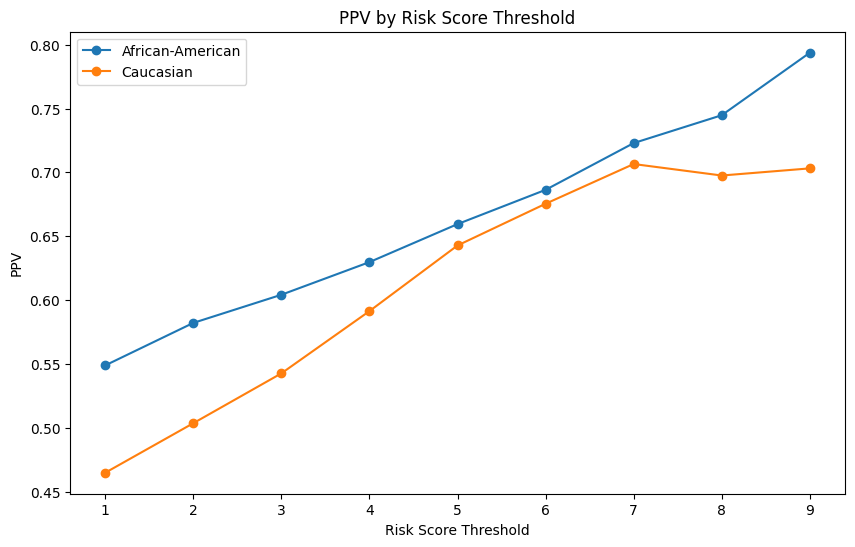

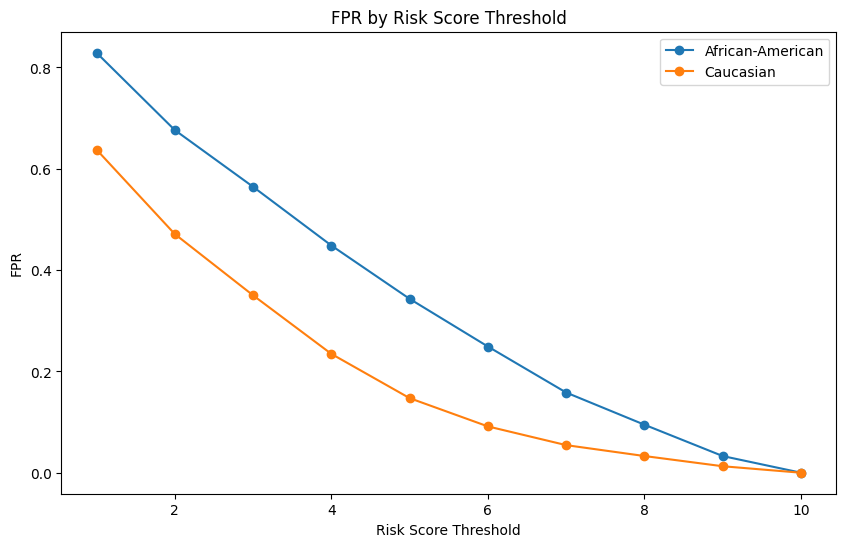

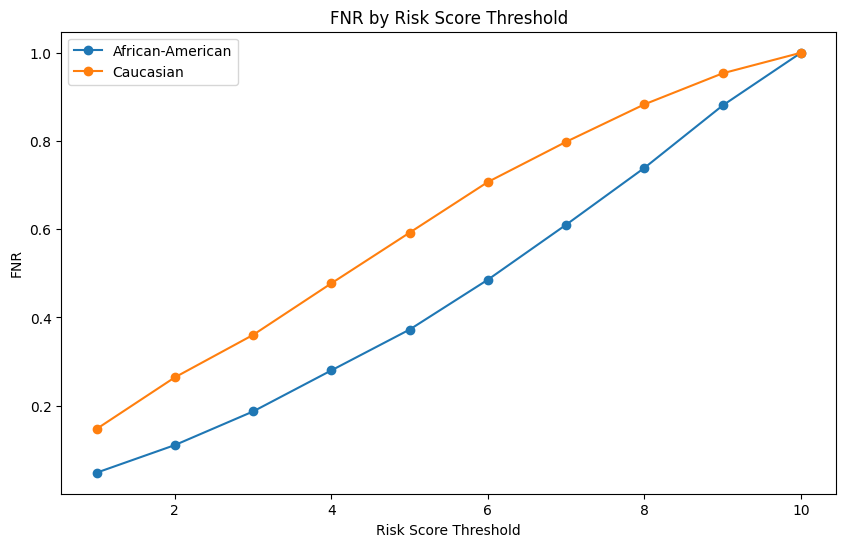

In [ ]:
thresholds = range(1, 11)
metrics_by_threshold = {}

for threshold in thresholds:
    data['prediction'] = (data['decile_score'] > threshold).astype(int)
    metrics_by_threshold[threshold] = fairness_metrics(data, 'race', 'two_year_recid', 'prediction')

def plot_metric_by_threshold(metric):
    plt.figure(figsize=(10, 6))
    for race in ['African-American', 'Caucasian']:
        values = [metrics_by_threshold[t][race][metric] for t in thresholds]
        plt.plot(thresholds, values, marker='o', label=race)
    plt.xlabel('Risk Score Threshold')
    plt.ylabel(metric)
    plt.title(f'{metric} by Risk Score Threshold')
    plt.legend()
    plt.show()

plot_metric_by_threshold('PPV')
plot_metric_by_threshold('FPR')
plot_metric_by_threshold('FNR')

**Calibration Analysis**

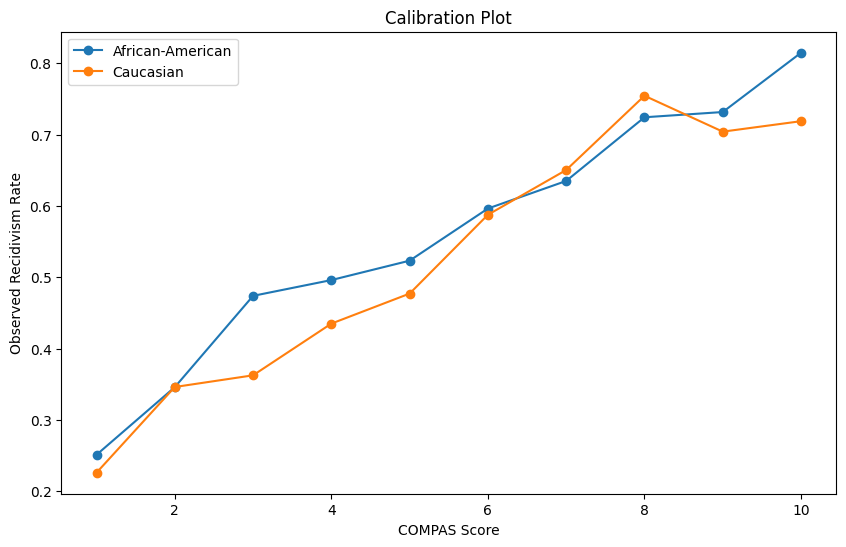

In [ ]:
def plot_calibration(data, race):
    race_data = data[data['race'] == race]
    observed_recid = race_data.groupby('decile_score')['is_recid'].mean()
    plt.plot(observed_recid.index, observed_recid.values, marker='o', label=race)
    plt.xlabel('COMPAS Score')
    plt.ylabel('Observed Recidivism Rate')
    plt.title('Calibration Plot')

plt.figure(figsize=(10, 6))
plot_calibration(data, 'African-American')
plot_calibration(data, 'Caucasian')
plt.legend()
plt.show()

**Predictive Parity and Error Rate Analysis**

In [ ]:
print(data['race'].value_counts())
print(data['two_year_recid'].value_counts())
print(data['decile_score'].value_counts())

race
African-American    3696
Caucasian           2454
Name: count, dtype: int64
two_year_recid
0    3283
1    2867
Name: count, dtype: int64
decile_score
1     1079
2      754
4      670
3      619
5      606
6      578
7      543
9      478
8      473
10     350
Name: count, dtype: int64


In [ ]:
data.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'is_high_risk', 'is_black'],
      dtype='object')

In [ ]:
print(data['r_charge_degree'].unique())

['(F3)' '(M1)' nan '(F2)' '(M2)' '(MO3)' '(F1)' '(F6)' '(F7)' '(CO3)']


In [ ]:
# Remove parentheses and handle NaN values
data['r_charge_degree'] = data['r_charge_degree'].str.strip('()').fillna('Unknown')

# Print unique values to confirm
print(data['r_charge_degree'].unique())

['F3' 'M1' 'Unknown' 'F2' 'M2' 'MO3' 'F1' 'F6' 'F7' 'CO3']


In [ ]:
print(data['r_charge_degree'].value_counts())
print(data.groupby(['race', 'two_year_recid', 'r_charge_degree']).size())

r_charge_degree
Unknown    3089
M1         1064
M2          951
F3          803
F2          150
F1           44
MO3          38
F7            6
F6            3
CO3           2
Name: count, dtype: int64
race              two_year_recid  r_charge_degree
African-American  0               F1                    1
                                  F2                    4
                                  F3                   38
                                  M1                   51
                                  M2                   40
                                  MO3                   1
                                  Unknown            1660
                  1               CO3                   1
                                  F1                   35
                                  F2                  110
                                  F3                  482
                                  F6                    3
                                  F7                

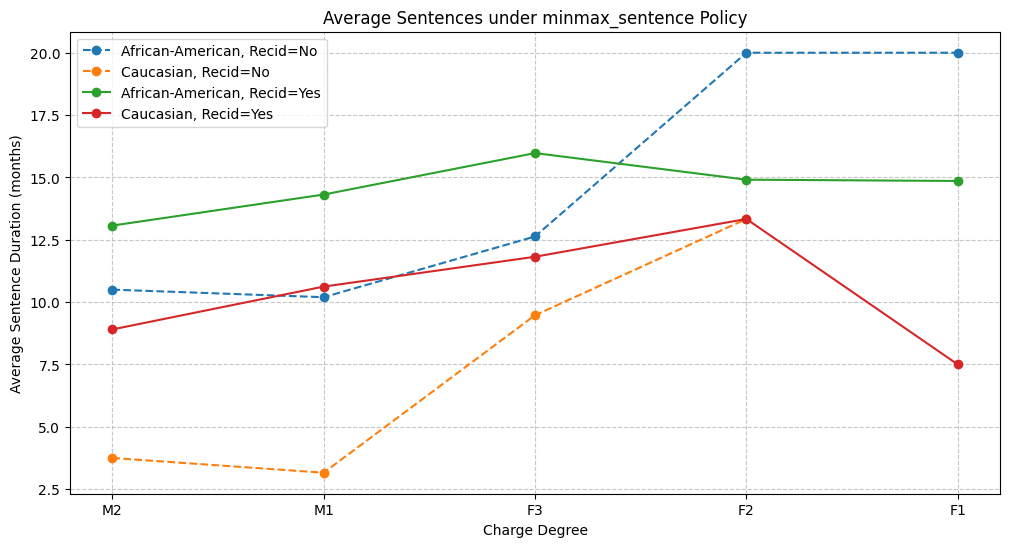

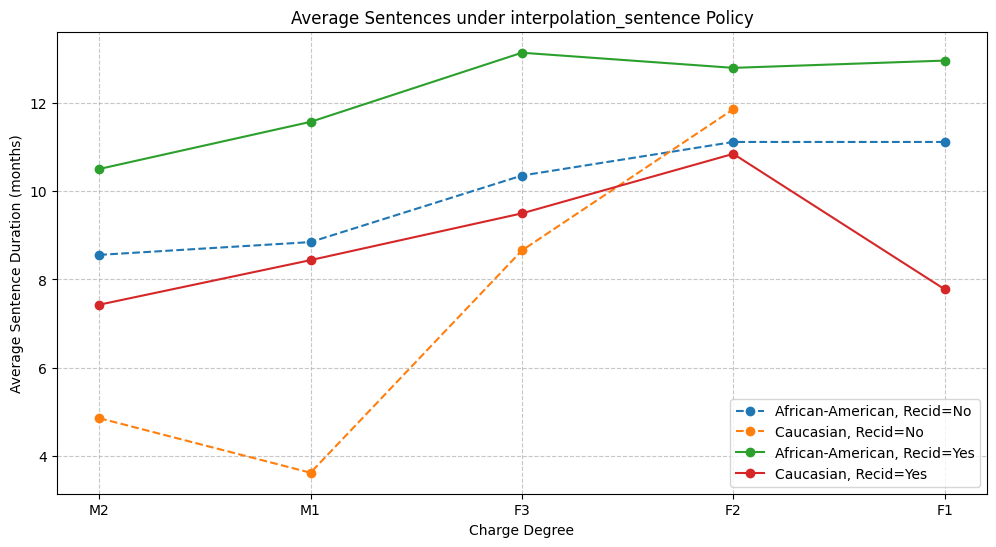

In [ ]:
def minmax_policy(score, tmin, tmax):
    return tmin if score <= 4 else tmax

def interpolation_policy(score, tmin, tmax):
    return tmin + (score - 1) / 9 * (tmax - tmin)

tmin, tmax = 0, 20  # As mentioned in the paper

data['minmax_sentence'] = data['decile_score'].apply(lambda x: minmax_policy(x, tmin, tmax))
data['interpolation_sentence'] = data['decile_score'].apply(lambda x: interpolation_policy(x, tmin, tmax))

# Plot the results
plot_average_sentences(data, 'minmax_sentence')
plot_average_sentences(data, 'interpolation_sentence')